In [1]:
from torch import nn
from torch.nn.functional import relu
import torch
import os
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from lib.models import Gandalf
from lib.utils import *

from torch.utils.data import DataLoader
from sklearn.metrics import ConfusionMatrixDisplay,classification_report

['E2-1', 'F1-1', 'C1-0', 'A1-1', 'E1-0', 'A4-0', 'B1-0', 'E4-0', 'F1-0', 'C4-1', 'D1-0', 'B3-1', 'C4-0', 'F5-1', 'E4-1'] ['A1-0']
testloader: 270 batches


100%|██████████| 270/270 [00:10<00:00, 24.70it/s]


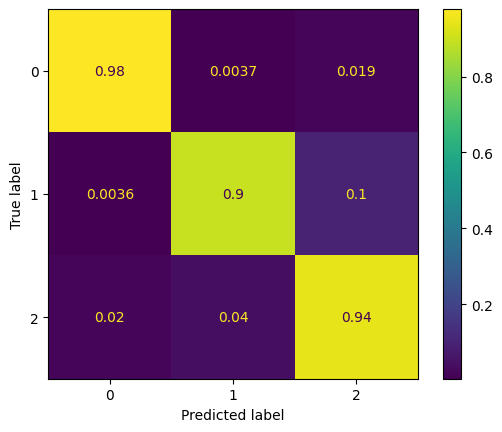

In [5]:
FOLD = 12

folds = get_leave_one_out_cv_ids_for_ekyn()
train_ids,test_ids = folds[FOLD]
print(train_ids,test_ids)
X,y = load_eeg_label_pair(id=test_ids[0],condition='PF',zero_pad=False)
testloader = DataLoader(Windowset(X,y),batch_size=32,shuffle=False)
print(f'testloader: {len(testloader)} batches')

model = Gandalf()
model.load_state_dict(torch.load(f=f'{GANDALFS_PATH}/gandalf_{FOLD}/best_model.pt',map_location='cpu',weights_only=False))
model.to(DEVICE)

criterion = torch.nn.CrossEntropyLoss()
loss,y_true,y_pred = evaluate(testloader,model,criterion,'cuda')
ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='true')
report = classification_report(y_true,y_pred,output_dict=True)

In [6]:
report

{'0': {'precision': 0.8497576736672051,
  'recall': 0.9776951672862454,
  'f1-score': 0.909248055315471,
  'support': 538.0},
 '1': {'precision': 0.9595007641365257,
  'recall': 0.8951996197718631,
  'f1-score': 0.926235554462749,
  'support': 4208.0},
 '2': {'precision': 0.8935286935286936,
  'recall': 0.9396507447354905,
  'f1-score': 0.9160095130804856,
  'support': 3894.0},
 'accuracy': 0.9203703703703704,
 'macro avg': {'precision': 0.9009290437774747,
  'recall': 0.937515177264533,
  'f1-score': 0.9171643742862351,
  'support': 8640.0},
 'weighted avg': {'precision': 0.9229339787639107,
  'recall': 0.9203703703703704,
  'f1-score': 0.9205689480178683,
  'support': 8640.0}}

In [5]:
from sklearn.metrics import ConfusionMatrixDisplay,classification_report

folds = get_leave_one_out_cv_ids_for_ekyn()
criterion = torch.nn.CrossEntropyLoss()
reports = []

for FOLD,(train_ids,test_ids) in tqdm(enumerate(folds)):
    model = Gandalf()
    model.load_state_dict(torch.load(f=f'{GANDALFS_PATH}/gandalf_{FOLD}/best_model.pt',map_location='cpu',weights_only=False))
    model.to(DEVICE)
    for condition in ['Vehicle','PF']:
        X,y = load_eeg_label_pair(id=test_ids[0],condition=condition,zero_pad=False)
        testloader = DataLoader(Windowset(X,y),batch_size=32,shuffle=False)
        loss,y_true,y_pred = evaluate(testloader,model,criterion,'cuda')
        report = classification_report(y_true,y_pred,output_dict=True)
        reports.append(report)

100%|██████████| 270/270 [00:10<00:00, 25.06it/s]
16it [05:32, 20.81s/it]


In [13]:
sum([report['macro avg']['f1-score'] for report in reports])

28.023380708340728

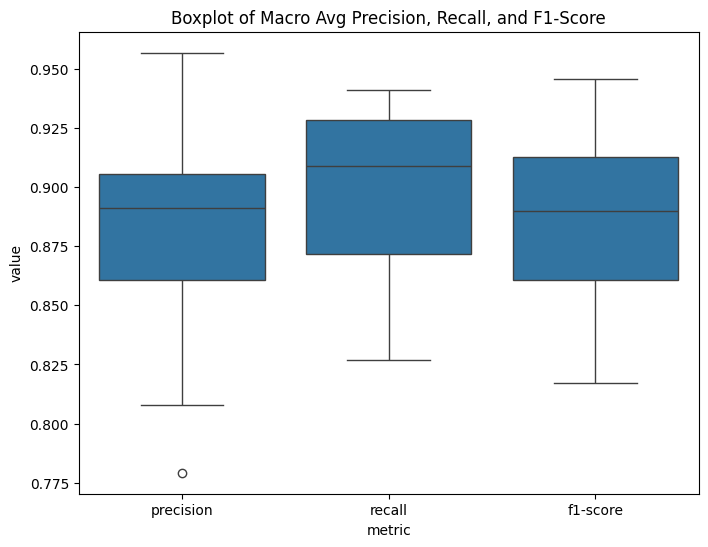

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Construct the DataFrame in wide format first
wide_df = pd.DataFrame({
    'precision': [report['macro avg']['precision'] for report in reports],
    'recall': [report['macro avg']['recall'] for report in reports],
    'f1-score': [report['macro avg']['f1-score'] for report in reports]
})

wide_df = wide_df.drop([11,28])

# Use melt to convert the wide DataFrame into long format
long_df = wide_df.melt(var_name='metric', value_name='value')

# Create the boxplot using the long format DataFrame
plt.figure(figsize=(8, 6))
sns.boxplot(x='metric', y='value', data=long_df)
plt.title('Boxplot of Macro Avg Precision, Recall, and F1-Score')
plt.show()

In [40]:
wide_df.describe()

,precision,recall,f1-score
count,30.000000,30.000000,30.000000
mean,0.884621,0.897675,0.886611
std,0.041328,0.035927,0.035094
min,0.779178,0.826689,0.817218
25%,0.860786,0.871707,0.860737
50%,0.891071,0.909097,0.889935
75%,0.905778,0.928521,0.912610
max,0.956885,0.941082,0.945833


In [37]:
wide_df

,precision,recall,f1-score
0,0.932259,0.934598,0.931689
1,0.884870,0.927510,0.902734
2,0.897553,0.926316,0.908641
3,0.915606,0.941082,0.926269
4,0.906826,0.906897,0.906848
5,0.956885,0.935910,0.945833
6,0.888204,0.884711,0.885998
7,0.895988,0.915470,0.904313
8,0.934882,0.917671,0.925950
9,0.902402,0.903259,0.902005


In [27]:
wide_df = df.pivot(columns='metric', values='value')
# wide_df.reset_index(drop=True, inplace=True)
wide_df

metric,f1-score,precision,recall
0,NaN,0.932259,NaN
1,NaN,NaN,0.934598
2,0.931689,NaN,NaN
3,NaN,0.884870,NaN
4,NaN,NaN,0.927510
...,...,...,...
91,NaN,NaN,0.875547
92,0.845134,NaN,NaN
93,NaN,0.835156,NaN
94,NaN,NaN,0.832323
